In [1]:
import PyPDF2
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

**Read our document**

Lets read our pdf using the PdfFileReader() function from the PyPDF2 which is a package for extracting document information such as title, author, number of pages,...., spliting documents page by page, merging page by page, etc.


In [2]:
filename = r'C:\Users\hayes\Documents\CV\sustainability-report-2021.pdf'
open_filename = open(filename, 'rb')
sus_report= PyPDF2.PdfFileReader(open_filename)

Xref table not zero-indexed. ID numbers for objects will be corrected.


- To get the document informtion using the getDocumentInfo() function 
- Check the number of pages in our document using the numPages() function


In [3]:
sus_report.getDocumentInfo()

{'/CreationDate': 'D:20220309163231Z',
 '/Creator': 'Adobe InDesign 17.1 (Macintosh)',
 '/ModDate': 'D:20220309163417Z',
 '/Producer': 'Adobe PDF Library 16.0.5',
 '/Trapped': '/False'}

In [4]:
total_pages = sus_report.numPages
total_pages

64

From the outputs of our two previous codes, we got the title of the document, what OS was used to type the document, when the document was created and modified. And we also got the total number of pages in our document.

**Lets extract the texts from the pdf file and print it.**

We will use a textract package to extract our texts from the document,  looping through all the pages in the document and extract the text from it.



The if statement check if our document returned words from the loop above using the extractText() function. This is done since PyPDF2 cannot read scanned documents.



In [5]:
import textract

In [6]:
count = 0
text  = ''

# Lets loop through, to read each page from the pdf file
while(count < total_pages):
    # Get the specified number of pages in the document
    mani_page  = sus_report.getPage(count)
    # Process the next page
    count += 1
    # Extract the text from the page
    text += mani_page.extractText()

In [7]:
if text != '':
    text = text
    
else:
    textract.process(open_filename, method='tesseract', encoding='utf-8', langauge='eng' )    

If the above returns a false, then run the Optical Character Recognition (OCR) textract to convert scanned/image based Pdf files to text. See textract online documentaion: textract.

Lets print out our texts to see what it contains which was converted to lower case using the lower() function.



In [8]:
from autocorrect import Speller
from nltk.tokenize import word_tokenize

In [17]:
import nltk
import re
import string
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from autocorrect import spell
nltk.download('punkt')
tt="Python is a programming language"
tokens=nltk.word_tokenize(tt)
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hayes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['Python', 'is', 'a', 'programming', 'language']

In [18]:

def to_lower(text):
    
    # Spell check the words
    spell  = Speller(lang='en')
    texts = spell(text)
    return ' '.join([w.lower() for w in word_tokenize(text)])

lower_case = to_lower(text)

**Clean our to_lower_case text variable and return it as a list of keywords.**
Our text contains unwanted characters such as spaces, punctuations \n and so forth.

Lets break our text phrases into individual words using word_tokenize() function from the Naturalge Toolkit (nltk).


In [19]:
def clean_text(lower_case):
    # split text phrases into words
    words  = nltk.word_tokenize(lower_case)
    
    
    # Create a list of all the punctuations we wish to remove
    punctuations = ['.', ',', '/', '!', '?', ';', ':', '(',')', '[',']', '-', '_', '%']
    
    # Remove all the special characters
    punctuations = re.sub(r'\W', ' ', str(lower_case))
    
    # Initialize the stopwords variable, which is a list of words ('and', 'the', 'i', 'yourself', 'is') that do not hold much values as key words
    stop_words  = stopwords.words('english')
    
    # Getting rid of all the words that contain numbers in them
    w_num = re.sub('\w*\d\w*', '', lower_case).strip()
    
    # remove all single characters
    lower_case = re.sub(r'\s+[a-zA-Z]\s+', ' ', lower_case)
    
    # Substituting multiple spaces with single space
    lower_case = re.sub(r'\s+', ' ', lower_case, flags=re.I)
    
    # Removing prefixed 'b'
    lower_case = re.sub(r'^b\s+', '', lower_case)
    
    
    
    # Removing non-english characters
    lower_case = re.sub(r'^b\s+', '', lower_case)
    
    # Return keywords which are not in stop words 
    keywords = [word for word in words if not word in stop_words  and word in punctuations and  word in w_num]
    
    return keywords

Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning.

In [24]:
nltk.download('omw-1.4')
# Lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()

lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in clean_text(lower_case)]

# lets print out the output from our function above and see how the data looks like
clean_data = ' '.join(lemmatized_word)


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hayes\AppData\Roaming\nltk_data...


In [25]:
# Lets save our data into a dataframe so we can do our analysis:
import pandas as pd
df = pd.DataFrame([clean_data])
df.columns = ['script']
df.index = ['Sus_Report']
df

,script
Sus_Report,taking step fairer future sustainability repor...


**Preprocess - Bag-of-Words Model:**

Bag-of-words(BoW) is a statistical language model used to analyze text and documents based on word count. The model does not account for word order within a document. BoW can be implemented as a Python dictionary with each key set to a word and each value set to the number of times that word appears in a text.


In [26]:
#  Counting the occurrences of tokens and building a sparse matrix of documents x tokens.
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

corpus = df.script
vect = CountVectorizer(stop_words='english')

# Transforms the data into a bag of words
data_vect = vect.fit_transform(corpus)

In [29]:
# The Document-term matrix is a mathematical matrix which decribes the frequency of words in a document
feature_names = vect.get_feature_names()
data_vect_feat = pd.DataFrame(data_vect.toarray(), columns=feature_names)
data_vect_feat.index = df.index
data = data_vect_feat.T
data

C:\Users\hayes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Sus_Report
abi,2
abiding,1
ability,6
able,9
absolutely,1
...,...
year,33
yoga,2
young,3
zer,1


**Getting the top 100 frequent words from the manifesto.**
We will try to get the top most common 100 words from our document and plot that into a wordcloud for visualization.

In [35]:
import matplotlib.pyplot as plt
import seaborn as sn

# Find the top 1000 words written in the manifesto
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False)
    top_dict[c]= list(zip(top.index, top.values))

    
for x in list(top_dict)[0:100]:
    print("key {}, value {} ".format(x,  top_dict[x]))

key Sus_Report, value [('sustainability', 117), ('report', 82), ('colleague', 79), ('customer', 69), ('work', 64), ('business', 55), ('group', 46), ('make', 45), ('emission', 42), ('company', 42), ('help', 40), ('way', 39), ('people', 39), ('life', 38), ('sustainable', 37), ('support', 35), ('financial', 35), ('year', 33), ('impact', 32), ('network', 31), ('change', 30), ('diversity', 30), ('new', 30), ('commitment', 29), ('positive', 28), ('inclusion', 28), ('carbon', 28), ('service', 26), ('future', 26), ('working', 25), ('executive', 24), ('investment', 24), ('social', 23), ('better', 23), ('responsible', 23), ('fair', 23), ('culture', 23), ('woman', 23), ('important', 22), ('world', 22), ('best', 21), ('create', 21), ('purpose', 21), ('want', 20), ('strategy', 20), ('risk', 19), ('goal', 19), ('opportunity', 19), ('action', 18), ('scope', 18), ('senior', 18), ('achieve', 18), ('solution', 17), ('bond', 17), ('ensure', 17), ('charter', 17), ('office', 16), ('champion', 16), ('need',

In [36]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 100 words
words = []
for p in data:
    top = [word for (word, count) in top_dict[p]]
    for t in top:
        words.append(t)

print(words[:10])

['sustainability', 'report', 'colleague', 'customer', 'work', 'business', 'group', 'make', 'emission', 'company']


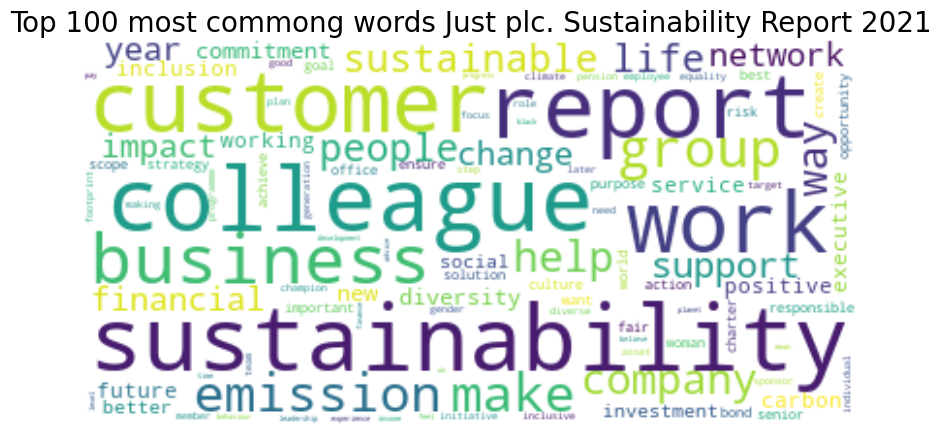

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


# Get 100 words based on the 
words_except_stop_dist = nltk.FreqDist(w for w in words[:100]) 
wordcloud = WordCloud(stopwords=set(STOPWORDS),background_color='white').generate(" ".join(words_except_stop_dist))
plt.imshow(wordcloud,interpolation = 'bilinear')
fig=plt.gcf()
fig.set_size_inches(10,12)
fig.set_dpi=125
plt.axis('off')
plt.title("Top 100 most common words Just plc. Sustainability Report 2021",fontsize=20)
plt.show();


**Sentiment Analysis of the Manifesto:**

This is a set of Natural Language Processing (NLP) technique of analysing, identifying and categorizing opinions expressed in a piece of text, in order to determine whether the writer's attitude towards a particular topic, product, politics, services, brands etc. is positive, negative, or neutral. 

This data holds immense value in the fields of marketing analysis, public relations, product reviews, net promoter scoring, product feedback, and customer service, for example.


In [53]:
from collections import defaultdict
from textblob import TextBlob

     ------------------------------------ 126.0/126.0 kB 410.3 kB/s eta 0:00:00



TextBlob function - returns two properties

Polarity: a float value which ranges from [-1.0 to 1.0] where 0 indicates neutral, +1 indicates most positive statement and -1 rindicates most negative statement.

Subjectivity: a float value which ranges from [0.0 to 1.0] where 0.0 is most objective while 1.0 is most subjective. Subjective sentence expresses some personal opinios, views, beliefs, emotions, allegations, desires, beliefs, suspicions, and speculations where as objective refers to factual information.



In [54]:
blob = TextBlob(clean_data)
blob.sentiment

Sentiment(polarity=0.17763762873351926, subjectivity=0.4329158525391406)

Developing a Model for ESG Analysis:
- Extract phrases and determine whether they are E, S, and or G.
    - Quantify it's importance: 
        - 'Policy to reduce carbon emissions' = 1
        - 'We have reduced carbon emissions by x%' = 2
- Weighted sum of ESG statements  - the higher the better?
- Scrape the web for ESG-related scandals, these would provide a counter-score to the ESG score
- Ratio of Un-ESG to ESG score may be used to obtain a 'ESG-washing' score/Client risk score which can also be used in client appraisal
    - i.e. Unethical Inc. scores a combined ESG score of 53 and an un-ESG score of 106, thus has a Client risk score of 2.
        - there are problems (ESG reports are not standardised, compromising inter-company comparisons; news articles relating to scandals are similarly not standardised...) 


**Topic modeling using LDA:**

Topic modeling can be seen as a type of statistical modeling for discovering the abstract 'topics' that are presented in a myriad of documents (it can be a single document). A topic is considered as a collection of prevalent keywords that are typical representatives. Its through keywords in which one determines what the topic is all about.


*What is LDA?*
Latent Dirichlet Allocation (LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s gensimpackage. We will therefore use LDA to classify text in our document to a particular topic. It works by building a topic per document model and words per topic model, from Dirichlet distribution models in statistics.

https://www.kaggle.com/code/jpandeinge/nlp-analysis-of-pdf-documents/notebook#Analysis-of-Independent-Presidential-Candidata-Dr.-Iitula's-Manifesto-for-2019--Election-Campaign

https://www.databricks.com/blog/2020/07/10/a-data-driven-approach-to-environmental-social-and-governance.html

https://www.researchgate.net/publication/361014122_Analyzing_and_Visualizing_Text_Information_in_Corporate_Sustainability_Reports_Using_Natural_Language_Processing_Methods

https://www.sesamm.com/blog/how-organizations-are-using-nlp-to-detect-greenwashing